In [1]:
%reload_ext autoreload
%autoreload 2
import pyxdf
import os
import numpy as np
from scipy import stats
from scipy.signal import medfilt, resample
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
from hampel import hampel
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import axes, bundles
from astropy.convolution import Gaussian1DKernel, convolve_fft

# Increase the resolution of all the plots below
bundles.beamer_moml()
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})


from utilities.utl import find_lsl_stream, find_nearest, fill_nan, axlines_with_text
from utilities.SingleSubjectData import SubjectData, Epochs

c:\Users\User\anaconda3\envs\venv_tremor_feedback\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","01_single_trial")
dir_prep = Path.joinpath(dir_script.parent.absolute(),"04_data","01_prep")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [3]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


In [4]:
# set params for epoch processing and plotting
cfg_gss_plot_colors = plt.cm.viridis(np.linspace(0,1,3))
cfg_trial_times = [0,30]
cfg_trial_times.sort()
cfg_epoch_times =  [0,30]
cfg_epoch_times.sort()

if np.max(cfg_trial_times) > np.diff(cfg_epoch_times):
    raise ValueError ('Time window of interest ouside epoch length')

# prelocate variables
tmp_fnms = fnms[10:11]
print([f.split('_')[0] for f in tmp_fnms])

id = []
n_trial = []
con_view_ang = []
con_feedback = []
per_bad_samples = []


for f in tmp_fnms:
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    if not sub.fsr:
        print(f'No GSS data found for {sub.id}')
        continue
        
    # prep raw 
    tmp_dat = medfilt(sub.fsr["time_series"][:,0],3)

    # epoch data
    eps = Epochs(sub,tmp_dat,times=sub.fsr["time_stamps"], events=sub.mrk, srate = 80, max_force = sub.max_force)

    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('trial_start*', idx_start=idx_exp_start,tmin=cfg_epoch_times[0],tmax=cfg_epoch_times[1],resample_epochs=True)  

    tmp_view_angle = eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2)


    fig, ax = plt.subplot_mosaic([['main']],
                              constrained_layout=True)
    # prep single trial pupil data
    for i in range(eps.data.shape[2]):

        raw = eps.data[0,:,i]

        if 0 <= i < 4:
            tmp_color = cfg_gss_plot_colors[0]
            tmp_label = 'visual'
        elif 4 <= i < 8:
            tmp_color = cfg_gss_plot_colors[1] 
            tmp_label = 'auditiv-visual'
        elif 8 <= i <12:
            tmp_color = cfg_gss_plot_colors[2]
            tmp_label = 'auditiv'      
           
        id.append(sub.id)
        n_trial.append(i)

        cfg_plot_lw = 1.5
        cfg_epoch_timevec = eps.times

        if tmp_view_angle.iloc[i] == .02:
            ls = 'dotted'
        elif tmp_view_angle.iloc[i] == .44:
            ls = 'solid'

        if i in [0,4,8]:
            ax["main"].plot(cfg_epoch_timevec,raw,color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls, label=tmp_label)
        else:
            ax["main"].plot(cfg_epoch_timevec,raw,color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls)


    # info per epoch
    con_view_ang.extend(tmp_view_angle)
    con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('epoch') ].str.split('_').str[1])

    sub_trials = pd.DataFrame()
    sub_trials["feedback_condition"] = con_feedback[-11:]

    axlines_with_text(ax["main"],5, 'Avg. start', axis='x')
    axlines_with_text(ax["main"],25, 'Avg. end', axis='x')
    ax["main"].set_xlabel('Time[s]')
    ax["main"].set_ylabel('Raw force [a.u.]')
    ax["main"].set_title(f"{sub.id} pupil epochs")
    ax["main"].legend(loc = 2) # set legend upper left 
    
    fig.savefig(Path.joinpath(dir_plots,f"{sub.id}_gss_epochs.png"))
    fig.clf()
    plt.close('all')




['c310']
Max force is 9064 something for c310


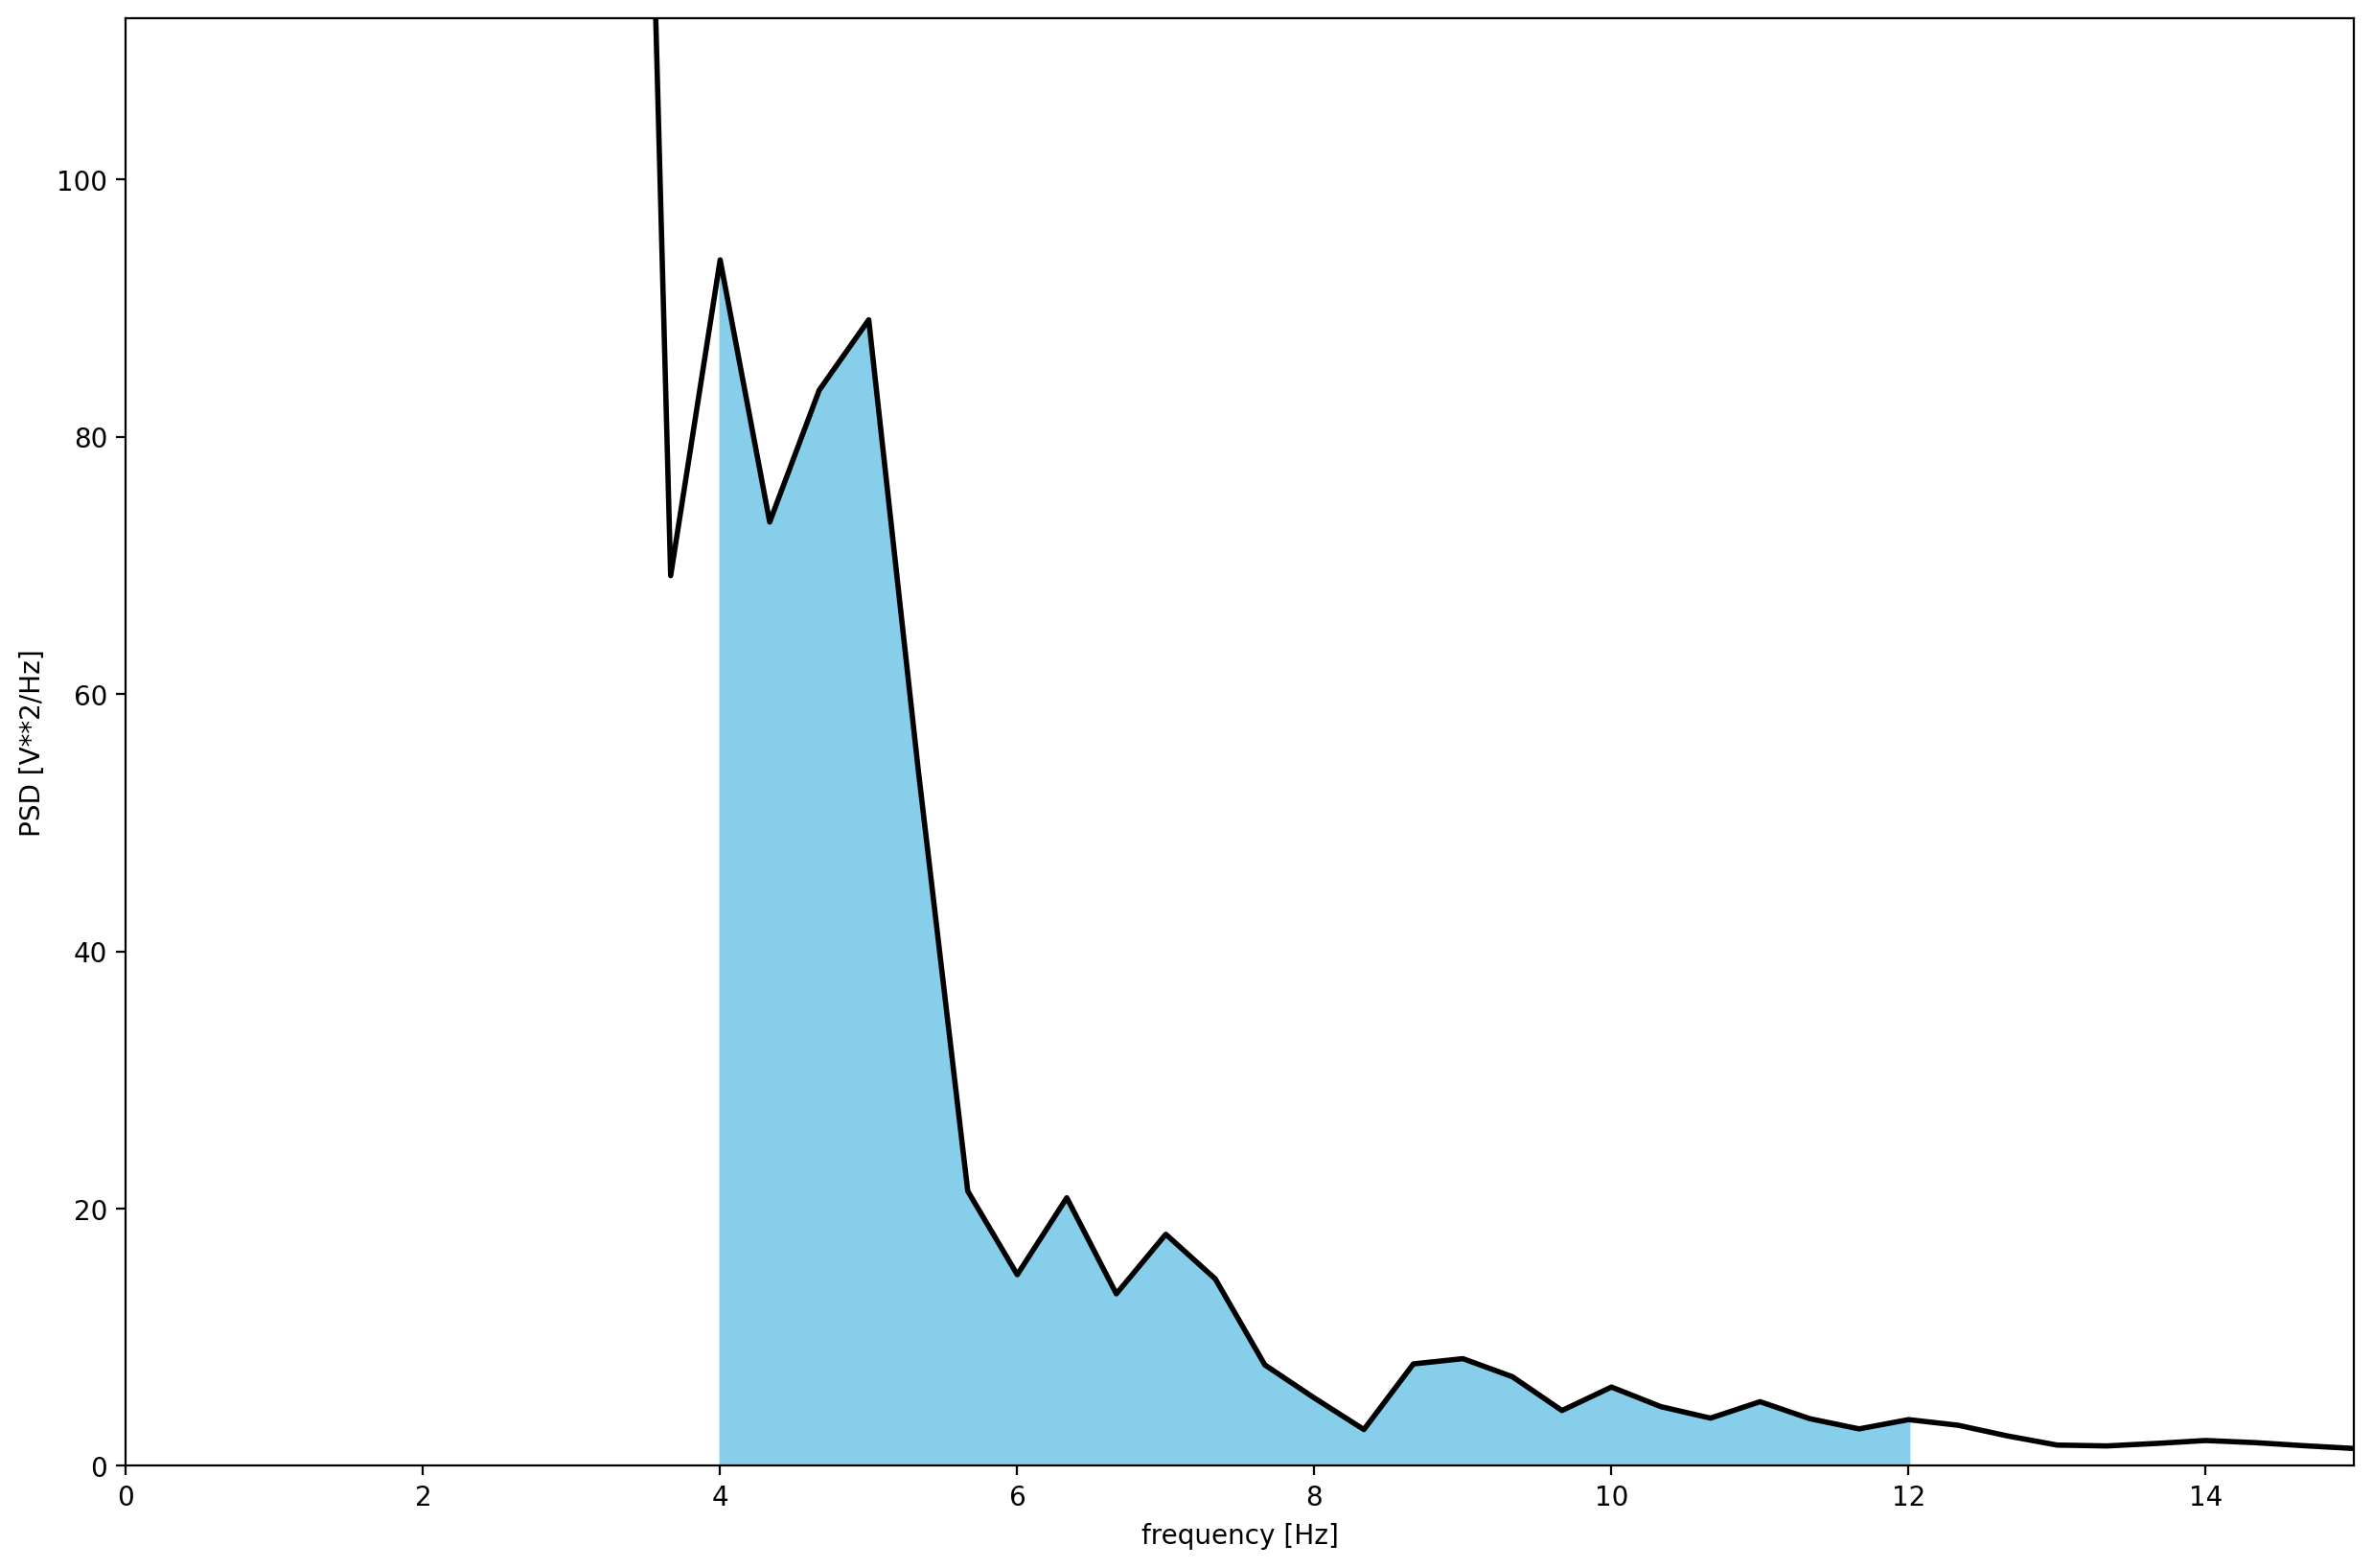

In [30]:

from scipy import signal
freqs, Pxx_den = signal.welch(eps.data[0,:,3], fs =  eps.srate, window='hann', nperseg=eps.srate*3, noverlap=eps.srate, scaling='density')

# Find intersecting values in frequency vector
idx_freq_oi = np.logical_and(freqs >= 4, freqs <= 12)

plt.plot(freqs, Pxx_den, lw=2, color='k')
plt.fill_between(freqs, Pxx_den, where=idx_freq_oi, color='skyblue')
plt.xlim(0,15)
plt.ylim(0,1.2 * max(Pxx_den[idx_freq_oi]))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
all_trials = {"ID": id, "Trial n": n_trial, "Feedback type": con_feedback, "Feedback angle": con_view_ang, "Pupil size": ppl_size, "Percentage bad pupil samples": per_bad_samples}
all_trials = pd.DataFrame(all_trials)

fname = "all_trials_gss.csv"

all_trials.to_csv(Path.joinpath(dir_prep,fname))


In [ ]:
from scipy.stats import ttest_ind
from scipy import stats
df = all_trials
ppl_z = np.abs(stats.zscore(df['Pupil size']))
df = df[ppl_z <  3]
df_ = df


#define samples
low = df_[df_["Feedback angle"]==0.02]
high = df_[df_["Feedback angle"]==0.44]

#perform independent two sample t-test
t_, p_ = ttest_ind(low['Pupil size'],high['Pupil size'])



Text(0.5, 1.0, 'p:0.002 easy vs. hard')

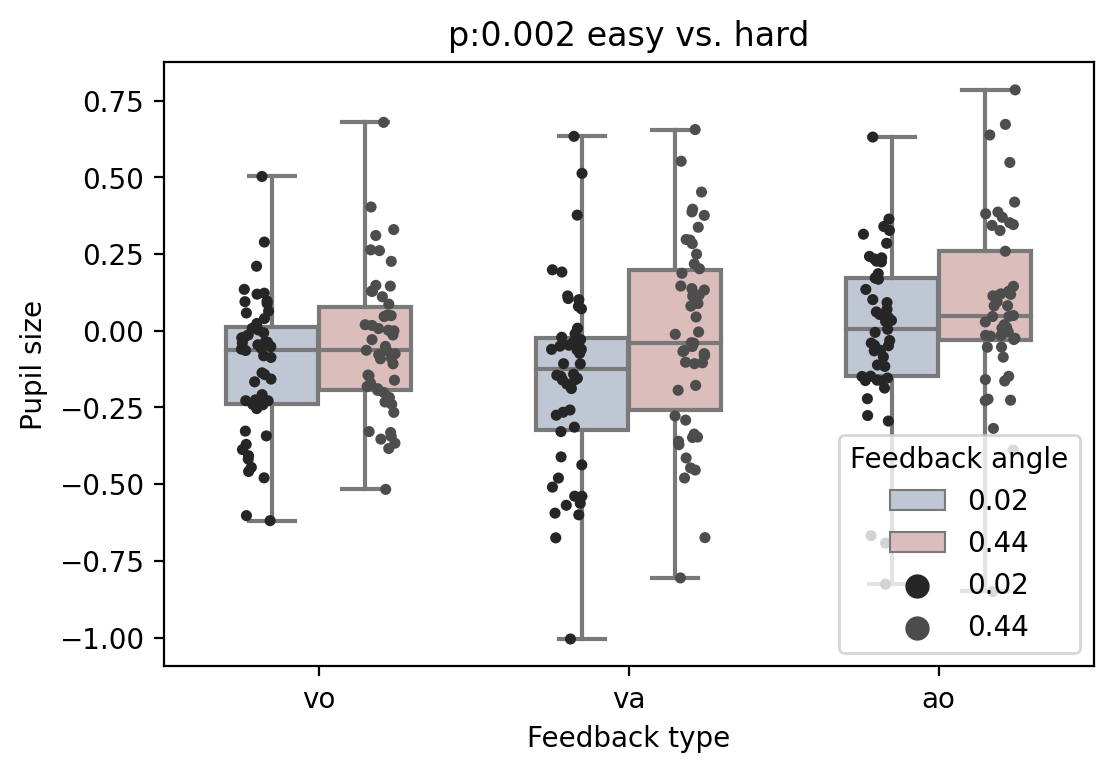

In [ ]:
import seaborn as sns

sns.boxplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(data=df,x="Feedback type",y="Pupil size",hue="Feedback angle",size=4, color=".3", linewidth=0,dodge=True)

plt.title(f"p:{round(p_,3)} easy vs. hard")